In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
print('Imported successfully')

Imported successfully


In [2]:
BASE_PATH = "/kaggle/input/pixel-play-26"
DATA_ROOT = os.path.join(BASE_PATH, os.listdir(BASE_PATH)[0])
AVENUE_PATH = os.path.join(DATA_ROOT, "Avenue_Corrupted")
DATASET = os.path.join(AVENUE_PATH, "Dataset")

TRAIN_VIDEOS = os.path.join(DATASET, "training_videos")
print(len(os.listdir(TRAIN_VIDEOS)))

16


In [3]:
def preprocess_frame(path, size=(64, 64)):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, size)
    normalized = resized / 255.0
    return normalized


In [4]:
train_video_ids = sorted(os.listdir(TRAIN_VIDEOS))

frames_data = []

for vid in train_video_ids[:3]:  # only first 3 videos
    vid_path = os.path.join(TRAIN_VIDEOS, vid)
    frame_files = sorted(os.listdir(vid_path))
    
    for f in frame_files[:100]:  # first 100 frames
        frame_path = os.path.join(vid_path, f)
        frame = preprocess_frame(frame_path)
        frames_data.append(frame)

frames_data = np.array(frames_data)
print(frames_data.shape)


(300, 64, 64)


In [5]:
num_frames = frames_data.shape[0]
X = frames_data.reshape(num_frames, -1)

print(X.shape)


(300, 4096)


In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [7]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

print(X_pca.shape)


(300, 50)


In [8]:
X_reconstructed = pca.inverse_transform(X_pca)

reconstruction_error = np.mean((X_scaled - X_reconstructed) ** 2, axis=1)

print("Mean error:", np.mean(reconstruction_error))
print("Max error:", np.max(reconstruction_error))


Mean error: 0.19299338969250526
Max error: 0.9506726988913182


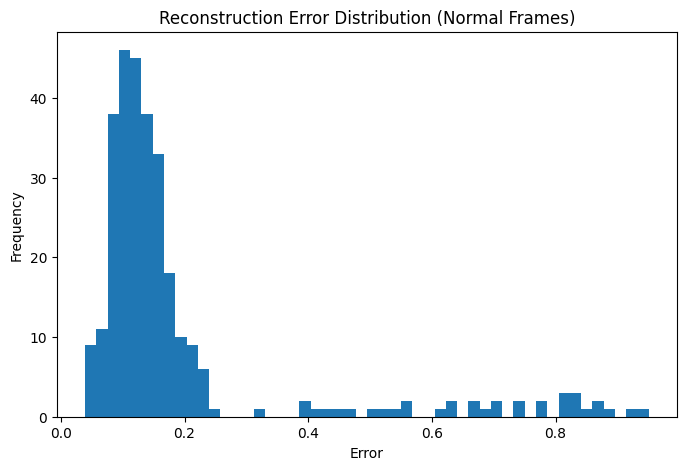

In [9]:
plt.figure(figsize=(8, 5))
plt.hist(reconstruction_error, bins=50)
plt.title("Reconstruction Error Distribution (Normal Frames)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()


In [10]:
frames_data = []

FRAME_STRIDE = 5   
MAX_FRAMES = 10000

count = 0

for vid in sorted(os.listdir(TRAIN_VIDEOS)):
    vid_path = os.path.join(TRAIN_VIDEOS, vid)
    frame_files = sorted(os.listdir(vid_path))
    
    for i, f in enumerate(frame_files):
        if i % FRAME_STRIDE != 0:
            continue
        
        frame_path = os.path.join(vid_path, f)
        frame = preprocess_frame(frame_path)
        frames_data.append(frame)
        
        count += 1
        if count >= MAX_FRAMES:
            break
    if count >= MAX_FRAMES:
        break

frames_data = np.array(frames_data)
print(frames_data.shape)


(1847, 64, 64)


In [11]:
X = frames_data.reshape(frames_data.shape[0], -1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [12]:
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_scaled)


In [13]:
import joblib

joblib.dump(pca, "/kaggle/working/pca_model.pkl")
joblib.dump(scaler, "/kaggle/working/scaler.pkl")


['/kaggle/working/scaler.pkl']

In [14]:
# Recompute training reconstruction errors

X_train = frames_data.reshape(frames_data.shape[0], -1)
X_train_scaled = scaler.transform(X_train)

X_train_pca = pca.transform(X_train_scaled)
X_train_recon = pca.inverse_transform(X_train_pca)

train_errors = np.mean((X_train_scaled - X_train_recon) ** 2, axis=1)

train_min = train_errors.min()
train_max = train_errors.max()

print("Train error min:", train_min)
print("Train error max:", train_max)

TEMPERATURE = 3.0


Train error min: 0.019737178402068612
Train error max: 0.9361131045564727


In [15]:
low_p = np.percentile(train_errors, 5)
high_p = np.percentile(train_errors, 95)

print("5th percentile:", low_p)
print("95th percentile:", high_p)


5th percentile: 0.04117904690428781
95th percentile: 0.842761631775239


In [16]:
REF_P = np.percentile(train_errors, 95)
print("95th percentile train error:", REF_P)


95th percentile train error: 0.842761631775239


In [17]:
train_mean = np.mean(train_errors)
train_std = np.std(train_errors)

print("Train mean error:", train_mean)
print("Train std error:", train_std)


Train mean error: 0.2567720634746724
Train std error: 0.2458378653248945


In [18]:
TEST_VIDEOS = os.path.join(DATASET, "testing_videos")
print(len(os.listdir(TEST_VIDEOS)))


21


In [19]:
video_errors = {}

In [20]:


TEST_VIDEOS = os.path.join(DATASET, "testing_videos")

for vid in sorted(os.listdir(TEST_VIDEOS)):
    vid_path = os.path.join(TEST_VIDEOS, vid)
    if not os.path.isdir(vid_path):
        continue

    vid_int = int(vid)
    video_errors[vid_int] = []

    frame_files = sorted(os.listdir(vid_path))

    for f in frame_files:
        if not f.endswith(".jpg"):
            continue

        frame_num = int(f.split('_')[-1].split('.')[0])
        frame_path = os.path.join(vid_path, f)

        frame = preprocess_frame(frame_path)
        frame_flat = frame.reshape(1, -1)

        frame_scaled = scaler.transform(frame_flat)
        frame_pca = pca.transform(frame_scaled)
        frame_recon = pca.inverse_transform(frame_pca)

        error = np.mean((frame_scaled - frame_recon) ** 2)

        video_errors[vid_int].append((frame_num, error))


In [21]:
print("Number of videos:", len(video_errors))
for k in list(video_errors.keys())[:3]:
    print("Video", k, "frames:", len(video_errors[k]))


Number of videos: 21
Video 1 frames: 499
Video 2 frames: 1211
Video 3 frames: 737


In [22]:
results = []

for vid, frames in video_errors.items():
    frames = sorted(frames, key=lambda x: x[0])
    errors = np.array([e for _, e in frames])

    min_e = errors.min()
    max_e = errors.max()

    if max_e - min_e < 1e-8:
        norm_errors = np.zeros_like(errors)
    else:
        norm_errors = (errors - min_e) / (max_e - min_e)

    for (frame_num, _), score in zip(frames, norm_errors):
        results.append({
            "Id": f"{vid}_{frame_num}",
            "Predicted": float(score)
        })


In [23]:
submission = pd.DataFrame(results)

submission[['vid', 'frame']] = submission['Id'].str.split('_', expand=True).astype(int)
submission = submission.sort_values(['vid', 'frame'])
submission = submission.drop(columns=['vid', 'frame'])

submission.to_csv("/kaggle/working/submission.csv", index=False)
submission.head()



,Id,Predicted
0,1_939,0.146690
1,1_940,0.179285
2,1_941,0.180338
3,1_942,0.142760
4,1_943,0.129164


In [24]:
submission['Predicted'].describe()


count    11706.000000
mean         0.112198
std          0.292452
min          0.000000
25%          0.003967
50%          0.011951
75%          0.021587
max          1.000000
Name: Predicted, dtype: float64

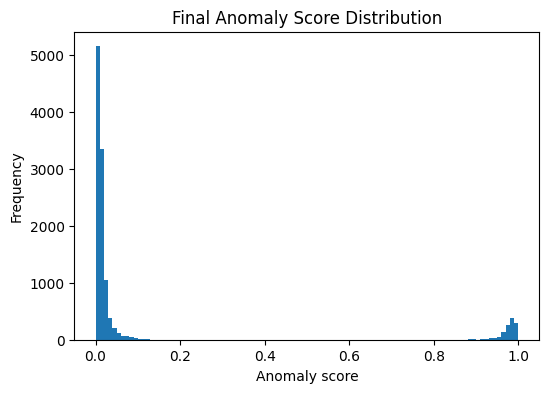

In [25]:
plt.figure(figsize=(6,4))
plt.hist(submission['Predicted'], bins=100)
plt.xlabel("Anomaly score")
plt.ylabel("Frequency")
plt.title("Final Anomaly Score Distribution")
plt.show()


In [26]:
submission.to_csv("/kaggle/working/submission.csv", index=False)
print("Saved submission.csv")


Saved submission.csv
